Markov Jump Process: Reaction Network
======================================

We consider the two Markov jump process models $m_1$ and $m_2$ for conversion of (chemical) species $X$ to species $Y$:

$$
  m_1: X + Y \xrightarrow{k_1} 2Y\\ m_2: X \xrightarrow{k_2} Y.
$$

Each model is equipped with a single rate parameter $k$.
To simulate these models, we define a simple Gillespie simulator:

In [1]:
import scipy as sp

def h(x, pre, c):
    return (x**pre).prod(1) * c

def gillespie(x, c, pre, post, max_t):
    """
    Gillespie simulation
    
    Parameters
    ----------
    
    x: 1D array of size n_species
        The initial numbers.
    
    c: 1D array of size n_reactions
        The reaction rates.
    
    pre: array of size n_reactions x n_species
        What is to be consumed.
    
    post: array of size n_reactions x n_species
        What is to be produced
    
    max_t: int
        Timulate up to time max_t
        
    Returns
    -------
    t, X: 1d array, 2d array
        t: The time points.
        X: The history of the species.
           ``X.shape == (t.size, x.size)``
    
    """
    t = 0
    t_store = [t]
    x_store = [x.copy()]
    S = post - pre

    while t < max_t:
        h_vec = h(x, pre, c)
        h0 = h_vec.sum()
        if h0 == 0:
            break
        delta_t = sp.random.exponential(1 / h0)
        # no reaction can occur any more
        if not sp.isfinite(delta_t):
            t_store.append(max_t)
            x_store.append(x)
            break
        reaction = sp.random.choice(c.size, p=h_vec/h0)
        t = t + delta_t
        x = x + S[reaction]
        
        t_store.append(t)
        x_store.append(x)

    return sp.asarray(t_store), sp.asarray(x_store)

Next, we define the models in terms of ther initial molecule numbers $x_0$, an array ``pre`` which determines what is to be consumed (the left hand side of the reaction equations) and an array ``post`` which determines what is to be produced (the right hand side of the reaction equations).
Moreover, we define that the simulation time should not exceed ``MAX_T`` seconds.

Model 1 starts with initial concentrations $X=40$ and $Y=3$.
The reaction $X + Y \rightarrow 2Y$ is encoded in ``pre = [[1, 1]]`` and ``post = [[0, 2]]``.

In [2]:
MAX_T = 0.1

class Model1:
    __name__ = "Model 1"
    x0 = sp.array([40, 3])   # Initial molecule numbers
    pre = sp.array([[1, 1]], dtype=int)
    post = sp.array([[0, 2]])
    
    
    def __call__(self, par):
        t, X = gillespie(self.x0,
                         sp.array([float(par["rate"])]),
                         self.pre, self.post,
                         MAX_T)
        return {"t": t, "X" : X}

Model 2 inherits the initial concentration from model 1.
The reaction $X \rightarrow Y$ is incoded in ``pre = [[1, 0]]`` and ``post = [[0, 1]]``.

In [3]:
class Model2(Model1):
    __name__ = "Model 2"
    pre = sp.array([[1, 0]], dtype=int)
    post = sp.array([[0, 1]])

We draw one stochastic simulation from model 1 (the "Observation") and and one from model 2 (the "Competition") and visualize both

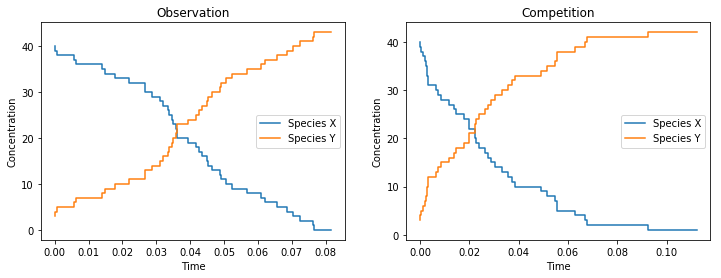

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

true_rate = 2.3
observations = [Model1()({"rate": true_rate}),
                Model2()({"rate": 30})]
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches((12, 4))
for ax, title, obs in zip(axes, ["Observation", "Competition"],
                          observations):
    ax.step(obs["t"], obs["X"]);
    ax.legend(["Species X", "Species Y"]);
    ax.set_xlabel("Time");
    ax.set_ylabel("Concentration");
    ax.set_title(title);

We observe that species $X$ is converted into species $Y$ in both cases.
The difference of the concentrations over time can be quite subtle.

We define a distance function as $L_1$ norm of two trajectories, evaluated at 20 time points:

$$
  \mathrm{distance}(X_1, X_2) =
     \sum_{n=1}^{N} 
           \left  |X_1(t_n) -X_2(t_n) 
           \right|, \quad t_n = \frac{n}{N}T, \quad  N=20 \,.
$$

Note that we only consider the concentration of species $X$ for distance calculation. And in code:

In [5]:
N_TEST_TIMES = 20

t_test_times = sp.linspace(0, MAX_T, N_TEST_TIMES)
def distance(x, y):
    xt_ind = sp.searchsorted(x["t"], t_test_times) - 1
    yt_ind = sp.searchsorted(y["t"], t_test_times) - 1
    error = (sp.absolute(x["X"][:,1][xt_ind]
                        - y["X"][:,1][yt_ind]).sum()
             / t_test_times.size)
    return error

For ABC, we choose for both models a uniform prior over the interval $[0, 100]$ for their single rate parameters:

In [6]:
from pyabc import Distribution, RV

prior = Distribution(rate=RV("uniform", 0, 100))

We initialize the ABCSMC class passing the two models, their priors and the distance function.

In [7]:
from pyabc import ABCSMC
from pyabc.populationstrategy import AdaptivePopulationSize

abc = ABCSMC([Model1(),
              Model2()],
             [prior, prior],
             distance,
             population_size=AdaptivePopulationSize(50, 0.15))

We initialize a new ABC run, taking as observed data the one generated by model 1.
The ABC run is to be stored in the sqlite database located at ``/tmp/mjp.db``.

In [8]:
abc_id = abc.new("sqlite:////tmp/mjp.db", observations[0])

INFO:Epsilon:initial epsilon is 13.05
INFO:History:Start <ABCSMC(id=8, start_time=2017-09-20 16:59:03.693494, end_time=None)>


We start pyABC which automatically parallelizes across all available cores.

In [9]:
history = abc.run(minimum_epsilon=0.7, max_nr_populations=15)

INFO:ABC:t:0 eps:13.05
INFO:ABC:t:1 eps:8.924999999999997
INFO:Adaptation:Change nr particles 50 -> 96
INFO:ABC:t:2 eps:6.4
INFO:Adaptation:Change nr particles 96 -> 94
INFO:ABC:t:3 eps:5.4
INFO:Adaptation:Change nr particles 94 -> 88
INFO:ABC:t:4 eps:4.711981600168074
INFO:Adaptation:Change nr particles 88 -> 89
INFO:ABC:t:5 eps:4.15
INFO:Adaptation:Change nr particles 89 -> 96
INFO:ABC:t:6 eps:3.6
INFO:Adaptation:Change nr particles 96 -> 118
INFO:ABC:t:7 eps:3.0
INFO:Adaptation:Change nr particles 118 -> 109
INFO:ABC:t:8 eps:2.352187767587535
INFO:Adaptation:Change nr particles 109 -> 94
INFO:ABC:t:9 eps:1.744885645843322
INFO:Adaptation:Change nr particles 94 -> 96
INFO:ABC:t:10 eps:1.4105891018502563
INFO:Adaptation:Change nr particles 96 -> 68
INFO:ABC:t:11 eps:1.2387047601774024
INFO:Adaptation:Change nr particles 68 -> 58
INFO:ABC:t:12 eps:1.0730813312941958
INFO:Adaptation:Change nr particles 58 -> 56
INFO:ABC:t:13 eps:0.95
INFO:Adaptation:Change nr particles 56 -> 57
INFO:ABC

We first inspect the model probabilities.

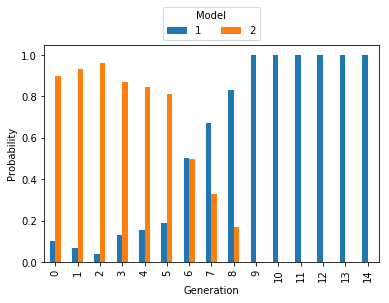

In [10]:
ax = history.get_model_probabilities().plot.bar();
ax.set_ylabel("Probability");
ax.set_xlabel("Generation");
ax.legend([1, 2], title="Model", ncol=2,
          loc="lower center", bbox_to_anchor=(.5, 1));

The mass at model 2 decreased, the mass at model 1 increased slowly.
The correct model 1 is detected towards the later generations.
We then inspect the distribution of the rate parameters:

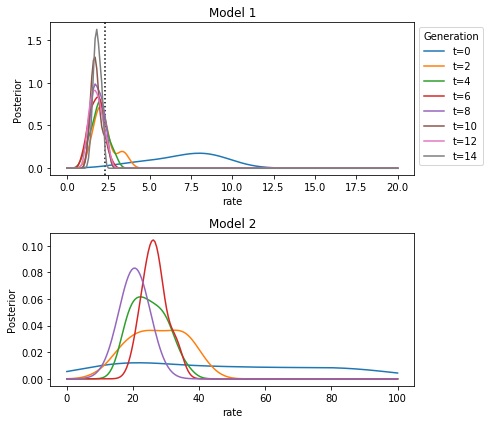

In [11]:
from pyabc.visualization import plot_kde_1d
fig, axes = plt.subplots(2)
fig.set_size_inches((6, 6))
axes = axes.flatten()
axes[0].axvline(true_rate, color="black", linestyle="dotted")
for m, ax in enumerate(axes):
    for t in range(0, history.n_populations, 2):
        df, w = history.get_distribution(m=m, t=t)
        if len(w) > 0:  # Particles in a model might die out
            plot_kde_1d(df, w, "rate", ax=ax, label=f"t={t}",
                        xmin=0, xmax=20 if m == 0 else 100,
                        numx=200)
    ax.set_title(f"Model {m+1}")
axes[0].legend(title="Generation",
          loc="upper left", bbox_to_anchor=(1, 1));

fig.tight_layout()

The true rate is closely approximated by the posterior over the rate of model 1.
It is a little harder to interpret the posterior over model 2.
Apparently a rate between 20 and 40 yields data most similar to the observed data.

Lastly, we visualize the evolution of the population sizes. The population sizes were automatically selected by pyABC and varied over the course of the generations.

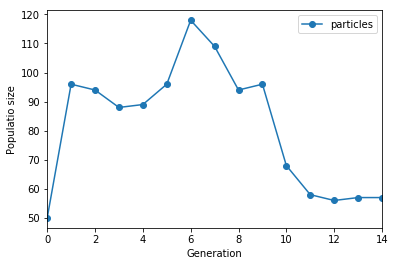

In [12]:
populations = history.get_all_populations()
ax = populations[populations.t >= 0].plot("t", "particles",
                                          style= "o-")
ax.set_xlabel("Generation")
ax.set_ylabel("Populatio size");

The initially chosen population size was too small for the desired target accuracy.
A larger population size was automatically selected by pyABC while both models were still alive. The population size decreased during the later populations thereby saving computational time.